## Configurations

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import torch
from torchvision import transforms
from torchvision.datasets import VOCSegmentation
from torch.utils.data import DataLoader, Dataset
from PIL import Image

# Configuration
DATA_DIR = "./data/voc"
IMG_SIZE = (256, 256)  # Resize images and masks to this size
BATCH_SIZE = 8
NUM_WORKERS = 2

## Dataset Creation

In [ ]:
import numpy as np
import torch
from torchvision import transforms

class VOCTransform:
    def __init__(self, img_size):
        self.img_size = img_size
        self.image_transform = transforms.Compose([
            transforms.Resize(img_size),
            transforms.ToTensor()
        ])
        self.mask_transform = transforms.Compose([
            transforms.Resize(img_size, interpolation=transforms.InterpolationMode.NEAREST)  # Use NEAREST for masks
        ])

    def __call__(self, img, target):
        # Transform the image
        img = self.image_transform(img)

        # Transform the mask
        target = self.mask_transform(target)
        target = np.array(target, dtype=np.float32)  # Convert to NumPy array

        # Convert to PyTorch tensor and binarize (values > 0 to 1.0)
        target = torch.tensor(target)
        target = torch.where(target > 0, torch.tensor(1.0), torch.tensor(0.0))

        return img, target


In [ ]:
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
from torchvision.datasets import VOCSegmentation
import torchvision.transforms as T

# Function to get train, validation, and test loaders
def get_voc_dataloaders(data_dir, img_size, batch_size, num_workers, years=["2010", "2011", "2012"],
                         train_split=0.8, val_split=0.1):
    # List to store the datasets for all years
    datasets = []

    # Apply the transformation
    transforms = VOCTransform(img_size=img_size)

    # Load data for each year and append to the datasets list
    for year in years:
        dataset = VOCSegmentation(
            root=data_dir,
            year=year,
            image_set="train",
            download=True,
            transforms=transforms,
        )
        datasets.append(dataset)

    # Combine datasets from multiple years
    full_dataset = torch.utils.data.ConcatDataset(datasets)

    # Calculate split sizes
    total_len = len(full_dataset)
    train_len = int(train_split * total_len)
    val_len = int(val_split * total_len)
    test_len = total_len - train_len - val_len

    # Split dataset into train, val, and test subsets
    train_dataset, val_dataset, test_dataset = random_split(
        full_dataset, [train_len, val_len, test_len]
    )

    # Create DataLoaders for each subset
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )

    return train_loader, val_loader, test_loader

In [ ]:
# Get train, validation, and test loaders
train_loader, val_loader, test_loader = get_voc_dataloaders(
    DATA_DIR, IMG_SIZE, BATCH_SIZE, NUM_WORKERS
)


Using downloaded and verified file: ./data/voc/VOCtrainval_03-May-2010.tar
Extracting ./data/voc/VOCtrainval_03-May-2010.tar to ./data/voc
Using downloaded and verified file: ./data/voc/VOCtrainval_25-May-2011.tar
Extracting ./data/voc/VOCtrainval_25-May-2011.tar to ./data/voc
Using downloaded and verified file: ./data/voc/VOCtrainval_11-May-2012.tar
Extracting ./data/voc/VOCtrainval_11-May-2012.tar to ./data/voc


## Visualizing Dataset

{0: 47535, 1: 18001}


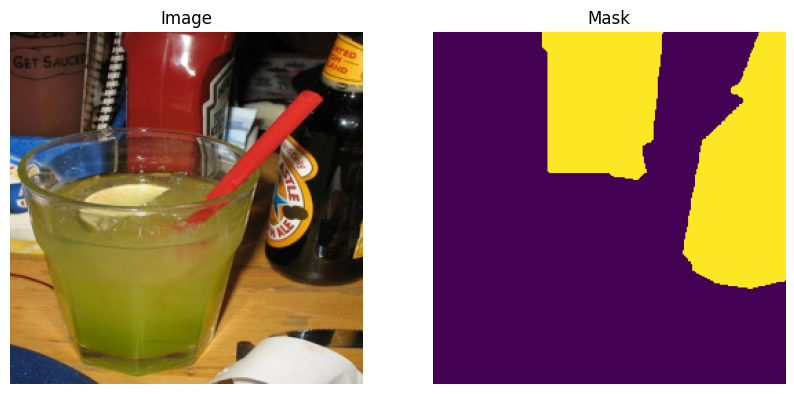

{0: 43905, 1: 21631}


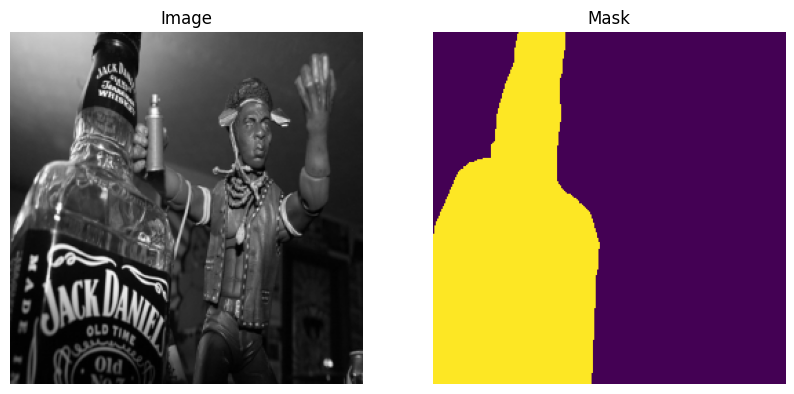

{0: 60937, 1: 4599}


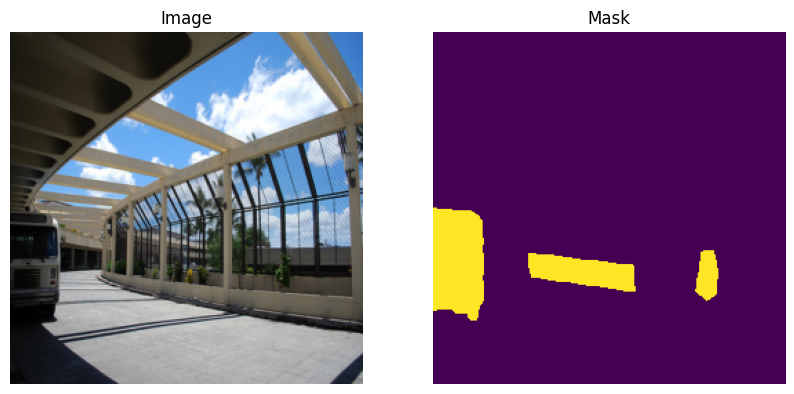

{0: 34928, 1: 30608}


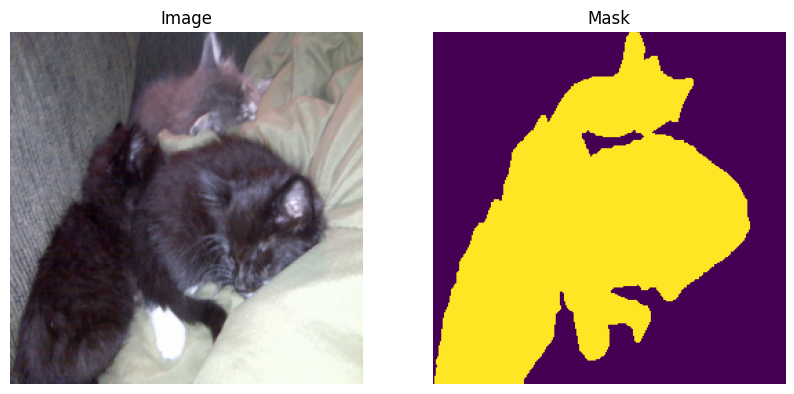

{0: 59968, 1: 5568}


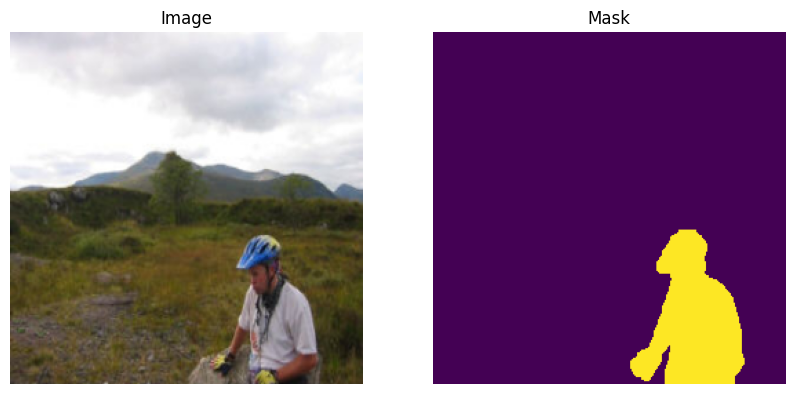

{0: 64735, 1: 801}


In [ ]:
import matplotlib.pyplot as plt


num_examples = 5
examples_shown = 0
for images, masks in train_loader:
    for i in range(images.size(0)):
        print({int(cls): (masks[i] == cls).sum().item() for cls in torch.unique(masks[i])})
        # np.set_printoptions(threshold=np.inf)
        # print(masks[i].squeeze().numpy())
        if examples_shown >= num_examples:
            break
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        # Display the image
        axes[0].imshow(transforms.ToPILImage()(images[i]))
        axes[0].set_title("Image")
        axes[0].axis("off")
        # Display the mask
        axes[1].imshow(masks[i].squeeze().numpy(), cmap="viridis")
        axes[1].set_title("Mask")
        axes[1].axis("off")
        plt.show()
        examples_shown += 1
    if examples_shown >= num_examples:
        break

Note for me: The boundaries are set to 1, background is set to 0, and the space inside the boundaries are set to 0.05

## Model Building

In [ ]:
import torch
import torch.nn as nn

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv_op(x)

In [ ]:
class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpSample, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x1, x2], 1)  # Concatenate along the channel dimension
        return self.conv(x)

class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownSample, self).__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        down = self.conv(x)
        p = self.pool(down)
        return down, p

In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(UNet, self).__init__()
        self.down_convolution_1 = DownSample(in_channels, 64)  # Reduced channels
        self.down_convolution_2 = DownSample(64, 128)  # Reduced channels
        self.down_convolution_3 = DownSample(128, 256)  # Reduced channels
        self.down_convolution_4 = DownSample(256, 512)  # Reduced channels

        self.bottle_neck = DoubleConv(512, 1024)  # Reduced channels

        self.up_convolution_1 = UpSample(1024, 512)  # Reduced channels
        self.up_convolution_2 = UpSample(512, 256)  # Reduced channels
        self.up_convolution_3 = UpSample(256, 128)  # Reduced channels
        self.up_convolution_4 = UpSample(128, 64)  # Reduced channels

        self.out = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)

    def forward(self, x):
        down_1, p1 = self.down_convolution_1(x)
        down_2, p2 = self.down_convolution_2(p1)
        down_3, p3 = self.down_convolution_3(p2)
        down_4, p4 = self.down_convolution_4(p3)

        b = self.bottle_neck(p4)

        up_1 = self.up_convolution_1(b, down_4)
        up_2 = self.up_convolution_2(up_1, down_3)
        up_3 = self.up_convolution_3(up_2, down_2)
        up_4 = self.up_convolution_4(up_3, down_1)

        out = self.out(up_4)
        return out

In [ ]:
# Initialize the U-Net model
model = UNet(in_channels=3, num_classes=1).to("cuda" if torch.cuda.is_available() else "cpu")
print(model)

UNet(
  (down_convolution_1): DownSample(
    (conv): DoubleConv(
      (conv_op): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down_convolution_2): DownSample(
    (conv): DoubleConv(
      (conv_op): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down_convolution_3): DownSample(
    (conv): DoubleConv(
      (conv_op): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), paddin

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total Parameters: {total_params}")

Total Parameters: 31031745


## Hyperparameter Tuning

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Define training parameters
device = "cuda" if torch.cuda.is_available() else "cpu"
num_epochs = 20
learning_rate = 3e-4

# Initialize the model, loss, and optimizer
criterion = nn.BCEWithLogitsLoss() # We only hav two classes
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# torch.cuda.empty_cache()

In [ ]:
print(f'train size: {len(train_loader.dataset)}')
print(f'val size: {len(val_loader.dataset)}')
print(f'test size: {len(test_loader.dataset)}')

train size: 2832
val size: 354
test size: 354


In [ ]:
# Define Dice Coefficient
def dice_coefficient(y_pred, y_true, threshold=0.5):
    """Calculate Dice coefficient."""
    y_pred = torch.sigmoid(y_pred)  # Apply sigmoid to logits
    y_pred = (y_pred > threshold).float()  # Threshold logits to binary values
    intersection = (y_pred * y_true).sum()
    union = y_pred.sum() + y_true.sum()
    dice = 2.0 * intersection / (union + 1e-6)  # Add small epsilon for numerical stability
    return dice.item()


## Load Checkpoint

In [ ]:
import os
import torch
import torch.nn.functional as F
from tqdm import tqdm

# Initialize lists to store losses and Dice coefficients
train_losses = []
val_losses = []
train_dcs = []
val_dcs = []

# Make sure to create a directory to save data
save_dir = "/content/drive/MyDrive/training_checkpoints"
os.makedirs(save_dir, exist_ok=True)

# Load checkpoint function
def load_checkpoint(model, optimizer, checkpoint_path):
    """Load the checkpoint if it exists, otherwise initialize everything."""
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        train_losses = checkpoint['train_losses']
        val_losses = checkpoint['val_losses']
        train_dcs = checkpoint['train_dcs']
        val_dcs = checkpoint['val_dcs']
        print(f"Loaded checkpoint from epoch {epoch}")
    else:
        epoch = 0  # Start from the first epoch if no checkpoint exists
        train_losses = []
        val_losses = []
        train_dcs = []
        val_dcs = []
        print("No checkpoint found, starting from scratch.")

    return model, optimizer, epoch, train_losses, val_losses, train_dcs, val_dcs

# Initialize model and optimizer
# model = YourModel()  # Define your model here
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  # Example optimizer, adjust as needed
checkpoint_path = os.path.join(save_dir, "/content/drive/MyDrive/training_checkpoints/model_2_epoch_30.pth")

# Load the checkpoint if available, otherwise initialize everything
model, optimizer, start_epoch, train_losses, val_losses, train_dcs, val_dcs = load_checkpoint(model, optimizer, checkpoint_path)

<ipython-input-161-c804175246af>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Loaded checkpoint from epoch 30


In [ ]:
# Training Loop
for epoch in range(start_epoch, 100):
    model.train()
    train_running_loss = 0
    train_running_dc = 0

    for idx, img_mask in enumerate(tqdm(train_loader, position=0, leave=True)):
        img = img_mask[0].float().to(device)
        mask = img_mask[1].float().to(device)
        mask = mask.unsqueeze(1)

        y_pred = model(img)

        optimizer.zero_grad()

        loss = criterion(y_pred, mask)
        train_running_loss += loss.item()
        train_running_dc += dice_coefficient(torch.sigmoid(y_pred), mask)

        loss.backward()
        optimizer.step()

    train_loss = train_running_loss / (idx + 1)
    train_dc = train_running_dc / (idx + 1)

    train_losses.append(train_loss)
    train_dcs.append(train_dc)

    model.eval()
    val_running_loss = 0
    val_running_dc = 0

    with torch.no_grad():
        for idx, img_mask in enumerate(tqdm(val_loader, position=0, leave=True)):
            img = img_mask[0].float().to(device)
            mask = img_mask[1].float().to(device)
            mask = mask.unsqueeze(1)

            y_pred = model(img)
            loss = criterion(y_pred, mask)
            val_running_loss += loss.item()
            val_running_dc += dice_coefficient(torch.sigmoid(y_pred), mask)

        val_loss = val_running_loss / (idx + 1)
        val_dc = val_running_dc / (idx + 1)

    val_losses.append(val_loss)
    val_dcs.append(val_dc)

    print("-" * 30)
    print(f"EPOCH {epoch + 1}")
    print(f"Training Loss: {train_loss:.4f} | Dice Coefficient: {train_dc:.4f}")
    print(f"Validation Loss: {val_loss:.4f} | Dice Coefficient: {val_dc:.4f}")
    print("-" * 30)

    # Save the model, loss, and dice values every 5 epochs
    if (epoch + 1) % 5 == 0:
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_dcs': train_dcs,
            'val_dcs': val_dcs
        }

        # Save model checkpoint
        checkpoint_path = os.path.join(save_dir, f"model_2_epoch_{epoch + 1}.pth")
        torch.save(checkpoint, checkpoint_path)

# Optional save at last
# torch.save(model.state_dict(), "final_model.pth")


100%|██████████| 45/45 [00:07<00:00,  6.40it/s]


------------------------------
EPOCH 32
Training Loss: 0.0565 | Dice Coefficient: 0.4718
Validation Loss: 0.2168 | Dice Coefficient: 0.4683
------------------------------


100%|██████████| 45/45 [00:07<00:00,  6.27it/s]


------------------------------
EPOCH 33
Training Loss: 0.0445 | Dice Coefficient: 0.4766
Validation Loss: 0.1965 | Dice Coefficient: 0.4605
------------------------------


100%|██████████| 45/45 [00:07<00:00,  6.21it/s]


------------------------------
EPOCH 34
Training Loss: 0.0378 | Dice Coefficient: 0.4922
Validation Loss: 0.2111 | Dice Coefficient: 0.4716
------------------------------


100%|██████████| 45/45 [00:07<00:00,  6.22it/s]


------------------------------
EPOCH 35
Training Loss: 0.0381 | Dice Coefficient: 0.4894
Validation Loss: 0.2705 | Dice Coefficient: 0.4458
------------------------------


  3%|▎         | 9/354 [00:04<02:46,  2.08it/s]


KeyboardInterrupt: 

## Test Predictions

DICE coefficient: 0.7124


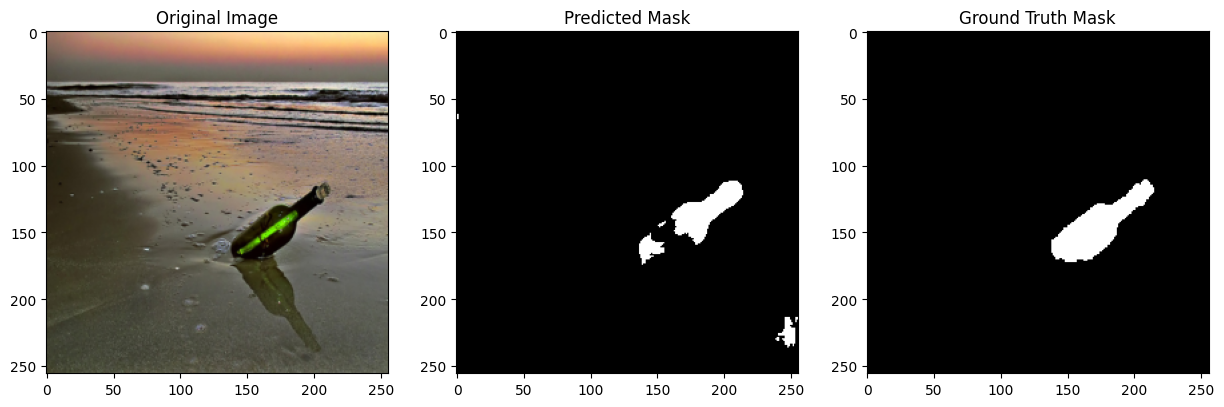

DICE coefficient: 0.9082


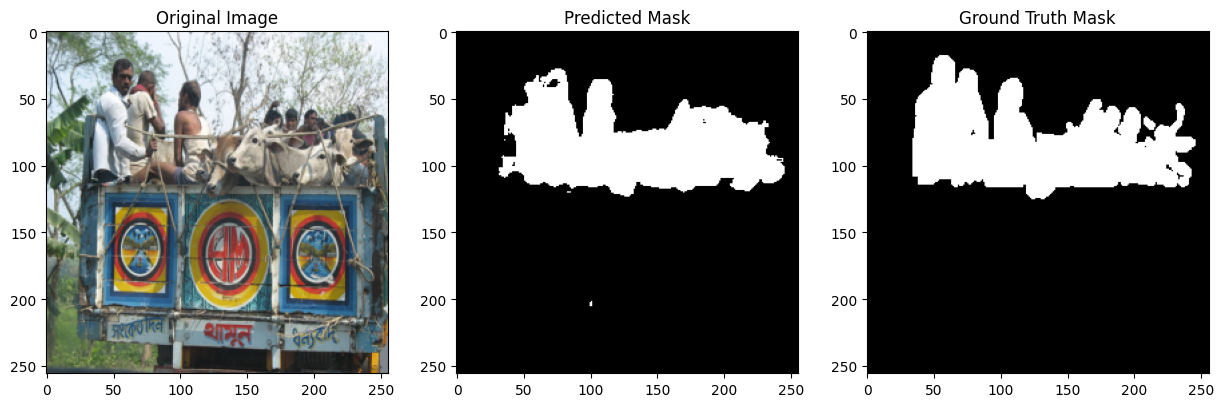

DICE coefficient: 0.5402


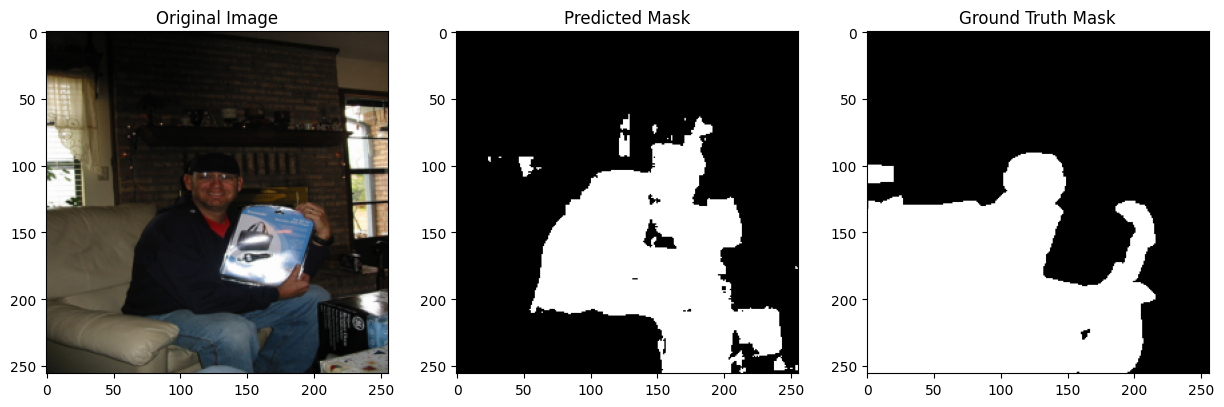

DICE coefficient: 0.9546


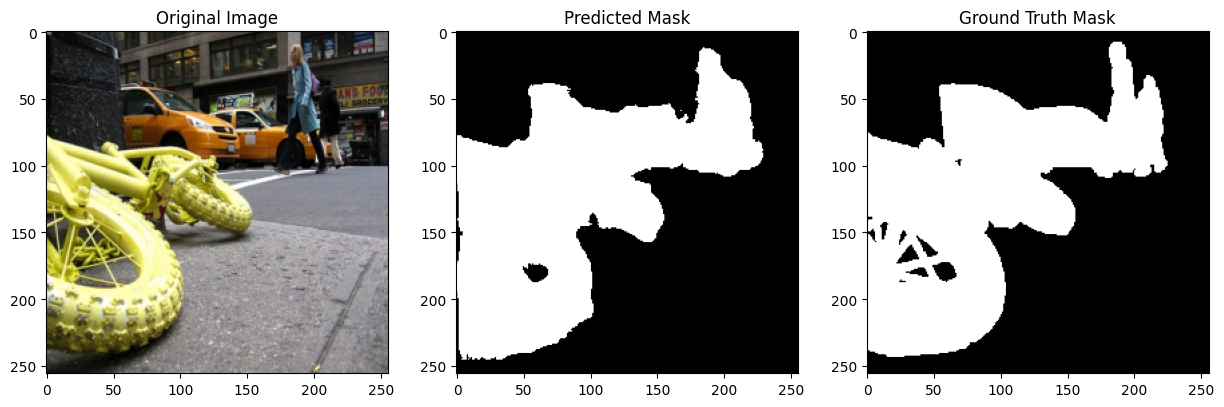

DICE coefficient: 0.1070


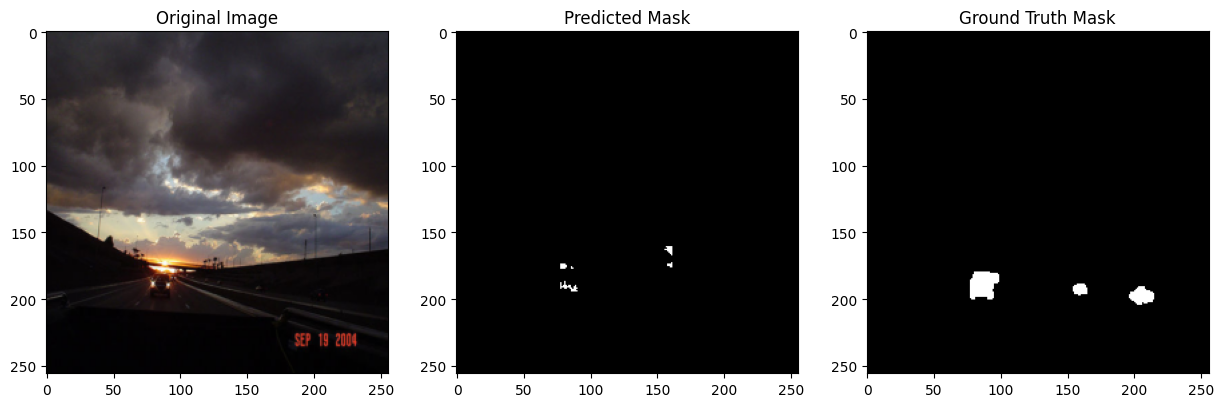

DICE coefficient: 0.2830


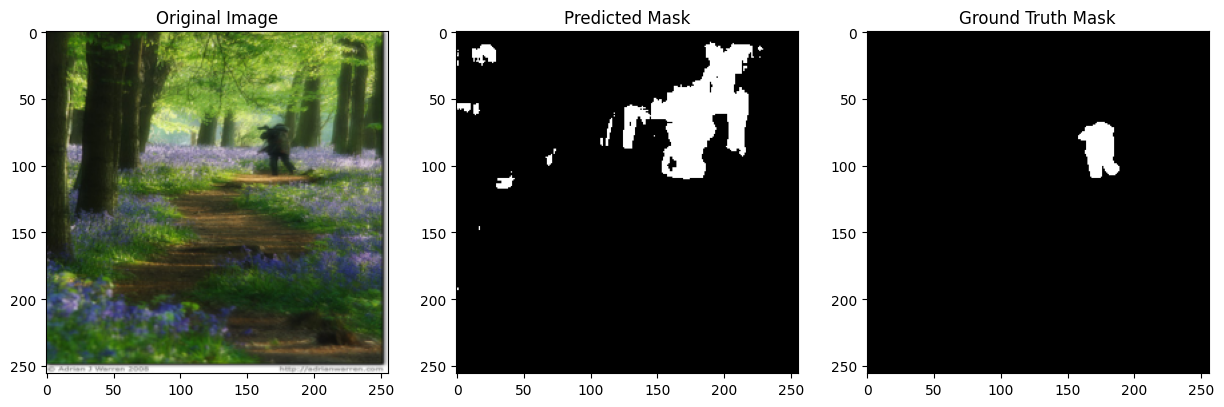

DICE coefficient: 0.9642


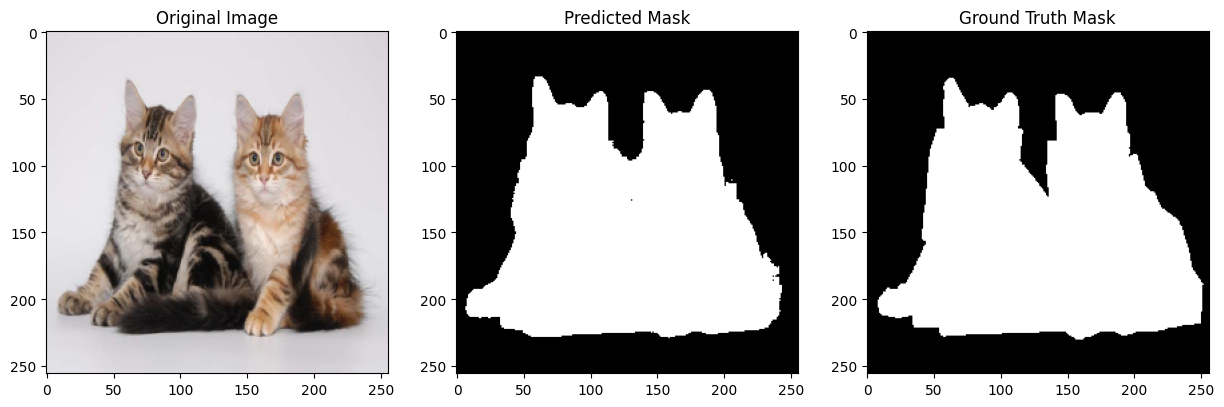

DICE coefficient: 0.9814


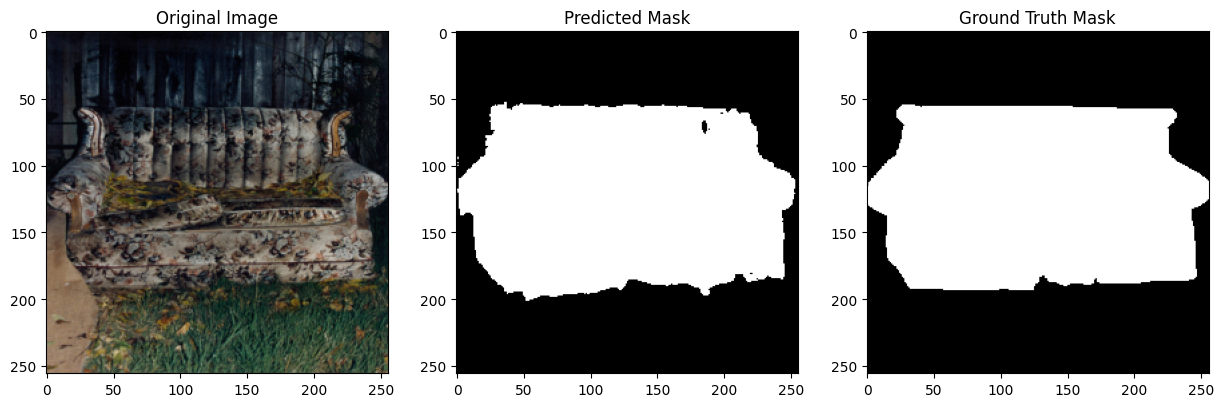

DICE coefficient: 0.9856


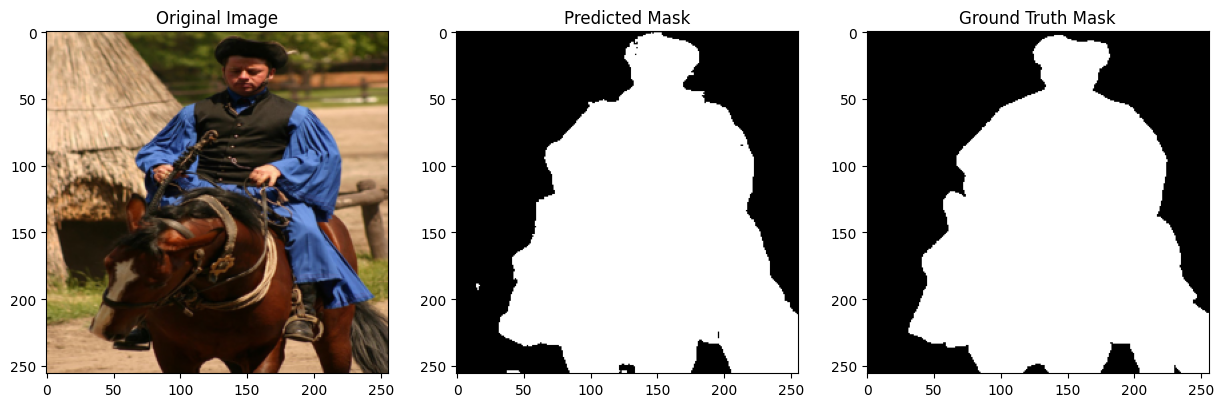

DICE coefficient: 0.9318


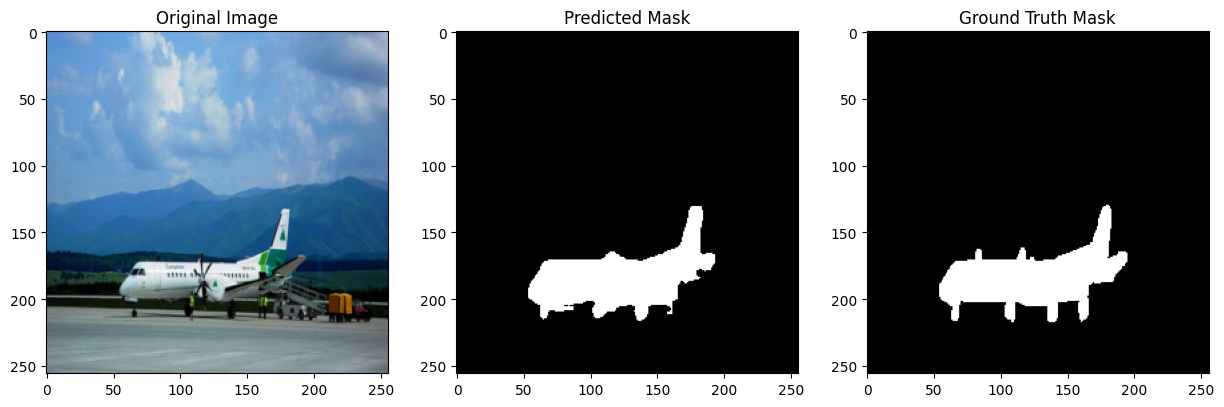

In [ ]:
import numpy as np
import torch
import random
import matplotlib.pyplot as plt

def random_images_inference(test_loader, model, device):
    # Switch model to evaluation mode
    model.eval()

    # Initialize lists to store results
    image_tensors = []
    mask_tensors = []

    # Randomly sample a few images for inference
    n = 10  # Number of random images to show
    start = 1
    for _ in range(n):
        random.seed(start + _)
        random_index = random.randint(0, len(test_loader.dataset) - 1)
        random_sample = test_loader.dataset[random_index]

        # Append the image and mask tensors
        image_tensors.append(random_sample[0])
        mask_tensors.append(random_sample[1])

    # Iterate over the images for inference
    with torch.no_grad():  # No gradients needed during inference
        for img_tensor, mask_tensor in zip(image_tensors, mask_tensors):
            img = img_tensor.float().unsqueeze(0).to(device)  # Add batch dimension
            mask = mask_tensor.float().unsqueeze(0).to(device)  # Ensure correct dtype

            # Model prediction
            y_pred = model(img)

            # Compute Dice coefficient (same as during training)
            dc = dice_coefficient(y_pred, mask)

            # Get the predicted mask (for evaluation purposes, applying sigmoid for binary output)
            pred_mask = torch.sigmoid(y_pred).squeeze(0).cpu().numpy() > 0.5
            # print(f'Predicted mask (binary):\n{pred_mask}')

            # Get ground truth mask
            target_mask = mask.squeeze(0).cpu().numpy()
            # print(f'True mask (binary):\n{target_mask}')

            # Print the DICE coefficient for each image
            print(f"DICE coefficient: {dc:.4f}")

            # Normalize the image for visualization
            img_norm = img_tensor.permute(1, 2, 0).cpu().numpy()  # Convert to (H, W, C)
            img_norm = np.clip(img_norm, 0, 1)  # Ensure pixel values are in range [0, 1]

            # Display the image, predicted mask, and ground truth mask
            plt.figure(figsize=(15, 5))

            plt.subplot(131)
            plt.imshow(img_norm)  # Original image
            plt.title("Original Image")

            # Display predicted mask in grayscale
            plt.subplot(132)
            plt.imshow(pred_mask.squeeze(), cmap='gray')  # Grayscale for binary mask
            plt.title("Predicted Mask")

            # Display the target mask in grayscale
            plt.subplot(133)
            plt.imshow(target_mask.squeeze(), cmap='gray')  # Grayscale for binary mask
            plt.title("Ground Truth Mask")

            plt.show()

# Example usage
random_images_inference(test_loader, model, device)


## Real data predictions

In [ ]:
import torch
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt

# Ensure that model is in evaluation mode
model.eval()

# Function to load and preprocess the image
def load_image(image_path):
    img = Image.open(image_path).convert("RGB")
    transform = T.Compose([
        T.Resize((256, 256)),  # Resize image to (256, 256)
        T.ToTensor(),
    ])
    img = transform(img).unsqueeze(0).to(device)  # Add batch dimension and move to device
    return img

# Function to predict mask from the model
def predict_mask(image_tensor):
    with torch.no_grad():
        y_pred = model(image_tensor)
        predicted_mask = torch.sigmoid(y_pred)  # Apply sigmoid to get probabilities
        predicted_mask = (predicted_mask > 0.5).float()  # Convert to binary mask
    return predicted_mask.squeeze(0).cpu()  # Remove batch dimension and move back to CPU


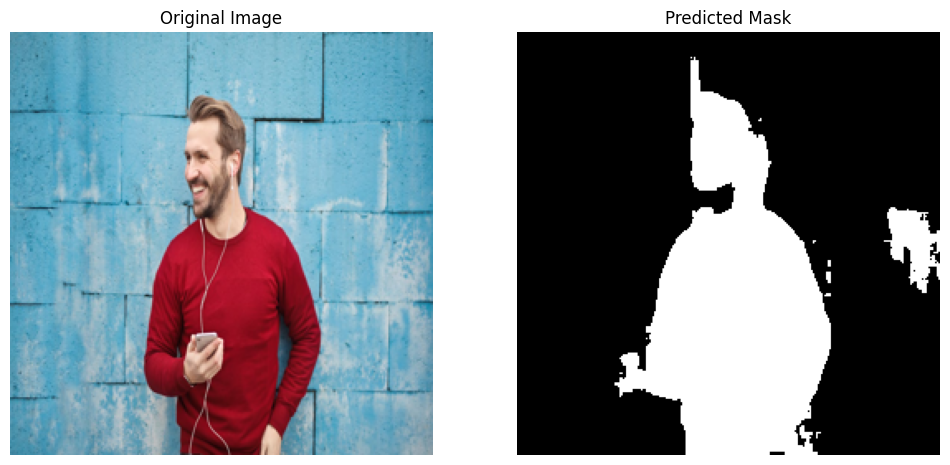

In [ ]:
image_path = "/content/guy.jpeg"  # Replace this with the path to your uploaded image
original_img = Image.open(image_path).convert("RGB")
original_img_resized = original_img.resize((256, 256))  # Resize original image to 256x256

# Predict the mask
image_tensor = load_image(image_path)
predicted_mask = predict_mask(image_tensor)

# Visualize the image and predicted mask
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Display resized original image
axes[0].imshow(original_img_resized)
axes[0].set_title("Original Image")
axes[0].axis("off")

# Display predicted mask
axes[1].imshow(predicted_mask.squeeze(), cmap="gray")  # Squeeze the mask to remove the singleton dimension
axes[1].set_title("Predicted Mask")
axes[1].axis("off")

plt.show()

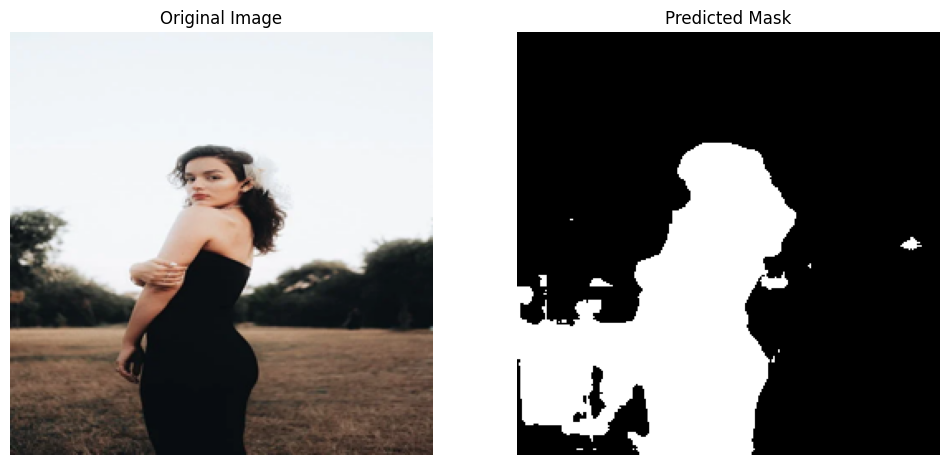

In [ ]:
image_path = "/content/girl1.webp"  # Replace this with the path to your uploaded image
original_img = Image.open(image_path).convert("RGB")
original_img_resized = original_img.resize((256, 256))  # Resize original image to 256x256

# Predict the mask
image_tensor = load_image(image_path)
predicted_mask = predict_mask(image_tensor)

# Visualize the image and predicted mask
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Display resized original image
axes[0].imshow(original_img_resized)
axes[0].set_title("Original Image")
axes[0].axis("off")

# Display predicted mask
axes[1].imshow(predicted_mask.squeeze(), cmap="gray")  # Squeeze the mask to remove the singleton dimension
axes[1].set_title("Predicted Mask")
axes[1].axis("off")

plt.show()

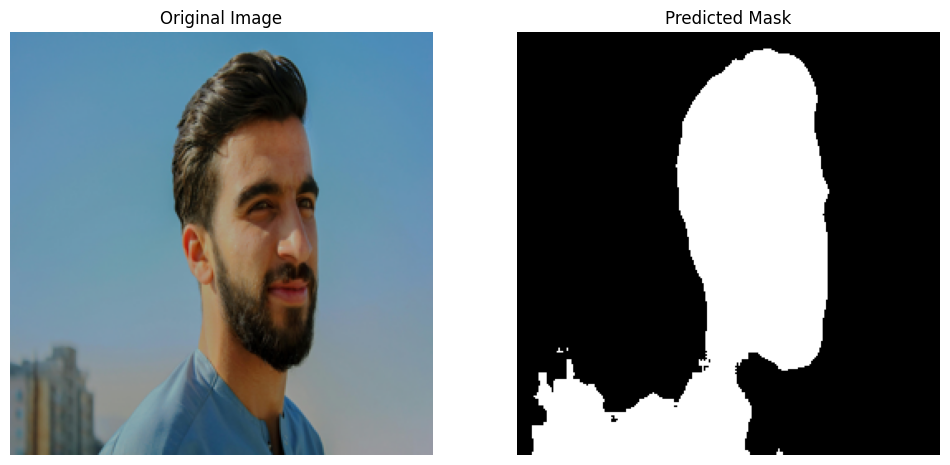

In [ ]:
image_path = "/content/guy2.jpg"  # Replace this with the path to your uploaded image
original_img = Image.open(image_path).convert("RGB")
original_img_resized = original_img.resize((256, 256))  # Resize original image to 256x256

# Predict the mask
image_tensor = load_image(image_path)
predicted_mask = predict_mask(image_tensor)

# Visualize the image and predicted mask
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Display resized original image
axes[0].imshow(original_img_resized)
axes[0].set_title("Original Image")
axes[0].axis("off")

# Display predicted mask
axes[1].imshow(predicted_mask.squeeze(), cmap="gray")  # Squeeze the mask to remove the singleton dimension
axes[1].set_title("Predicted Mask")
axes[1].axis("off")

plt.show()

# Hurrayy!! We are donee